In [11]:
from fastai.vision.all import *

In [3]:
path = '../input/fruit-images-for-object-detection/train_zip/train'

In [4]:
def label_func(label):
    """Get label from prefix of filename.
    
    apple_46.jpg -> apple
    """
    return label.name.split('_')[-2]

fruit = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=420),
    get_y=label_func,
    item_tfms=Resize(128)
)

In [5]:
dls = fruit.dataloaders(path)

Default resizing algorithm does a crop.

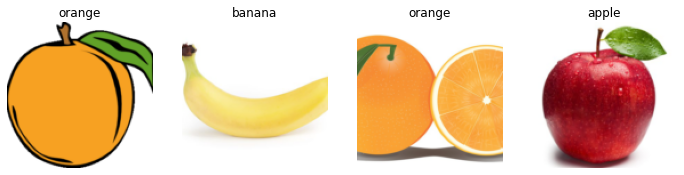

In [6]:
dls.valid.show_batch(max_n=4, nrows=1)

Can make a copy of a Datablock and change parameters as follows. I'm using it to change resize algorithm to squish

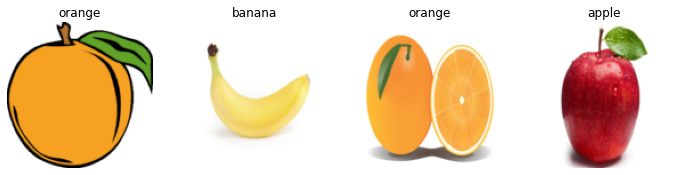

In [7]:
fruit = fruit.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = fruit.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Can also add black bars for padding

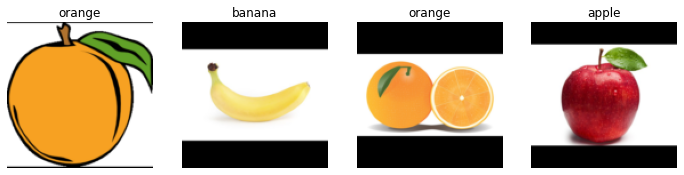

In [8]:
fruit = fruit.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = fruit.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Can also use reflect for pad mode

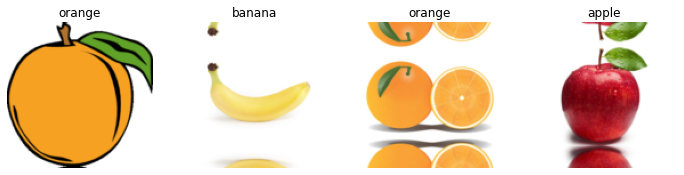

In [9]:
fruit = fruit.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='reflection'))
dls = fruit.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

## 00:03:28 - Question: why squares and not rectangles

* If you know all images are rectangles - or another aspect ratio - might as well keep the that way.
* If you have tall and some wide, it's easier to square them
    * Otherwise, you have to try to get tall and wide ones in each minibatch

## 00:05:18 - Using RandomResizeCrop

* Can see in the pad example that some images and wide and some are tall.
* All of the methods for resizing have downsizes:
  * pad has empty space, so you are wasting computation
  * squish is most efficient but changes aspect ratio. That could be bad if that's an important part of classification
  * default cropping approach removes some information
* RandomResizeCrop:
    * Crop a random part of the image and zoom in.

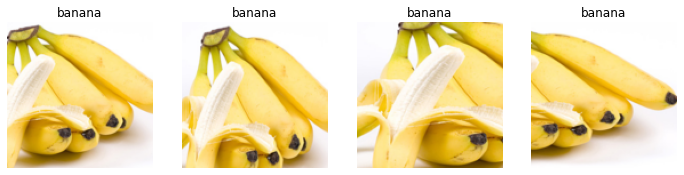

In [18]:
fruit = fruit.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = fruit.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

* Advantage of that it's a form of [[Data Augmentation]] - each epoch, the model will be trained on a slight variation of the original image

## 00:08:51 - Data Augmentations and aug_transforms

* Fast.ai provides a list of other data augmentations you can use in the `aug_transforms` function:

In [20]:
tfms = aug_transforms(mult=2)

In [26]:
tfms

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.4, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

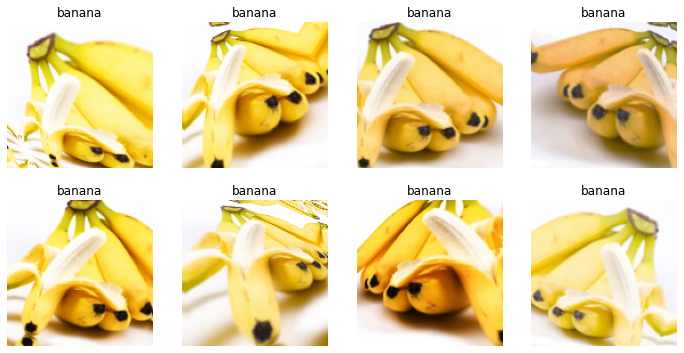

In [28]:
fruit = fruit.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = fruit.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

* Note that these are batch tfms:
    * they happen to a minibatch at a time on the GPU.
    * That means that the augmentation can happen really fast.
  
## 00:10:42 - Shift-tab in Juypter

* Press shift-tab in function parenthesis, will pop open a list of arguments.

## 00:11:10 - Question: how to add different augs for train and valid sets

* Fast.ai automatically avoids add augmentations to valid set. However, it does a centre crop.

## 00:12:29 - Cleaning data using a trained model

* As per last lesson, I can train the model:

In [29]:
fruit = fruit.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(mult=2))
dls = fruit.dataloaders(path)

In [30]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.307089,2.562253,0.812500,00:23


epoch,train_loss,valid_loss,error_rate,time
0,1.212541,1.191454,0.562500,00:28
1,0.990723,0.448721,0.187500,00:28
2,0.760288,0.244519,0.104167,00:28
3,0.616766,0.178925,0.083333,00:28


* We didn't do any data clearning, aside from validating each image can be opened.
    * It's much easier to clean your data after you create a model.
* Fast.ai has a tool called `ImageClassifierCleaner` that shows you the images that it's least confident about:

In [32]:
from fastai.vision.widgets import ImageClassifierCleaner

In [33]:
cleaner = ImageClassifierCleaner(learn)
cleaner

You can then iterate through all the "delete" ones and unlink them. Then move all the wrongly classified ones to the correct category.

In [34]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

In [35]:
for idx, category in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

## 00:15:53 - Jupyter notebooks widgets and fastbook reminder

* You can create guis/widgets inside Juypter notebooks.
* Reminder that the whole fastai book was written in Juypter notebooks.
  * Best place to learn how something was implemented is to look at notebooks, not modules

## 00:18:06 - Inference

* Can export to pickle file:

In [38]:
learn.export()

In [39]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [40]:
learn_inf = load_learner(path/'export.pkl')

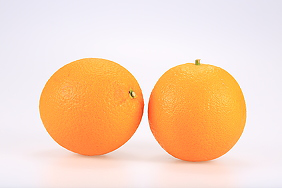

In [52]:
Image.open('../input/fruit-images-for-object-detection/test_zip/test/orange_93.jpg')

In [53]:
learn_inf.predict('../input/fruit-images-for-object-detection/test_zip/test/orange_93.jpg')

('orange', tensor(3), tensor([6.3892e-07, 2.1236e-07, 4.1997e-04, 9.9958e-01]))

The 4 things returned are the probabilities of each class. You can find the order by asking for the dataloaders vocab:

In [54]:
learn_inf.dls.vocab

['apple', 'banana', 'mixed', 'orange']

* Any time you have mapping from numbers to string, mapping is stored in vocab.

## 00:21:24 - Creating application from Juypter notebook

* Curated approach to building web applications from notebooks.
* Key pieces of technology:
  * IPython widgets (ipywidgets)
  * Voila

In [56]:
import ipywidgets as widgets

In [57]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

* `PILImage` can create images from binary blob, which is what `FileUpload` returns

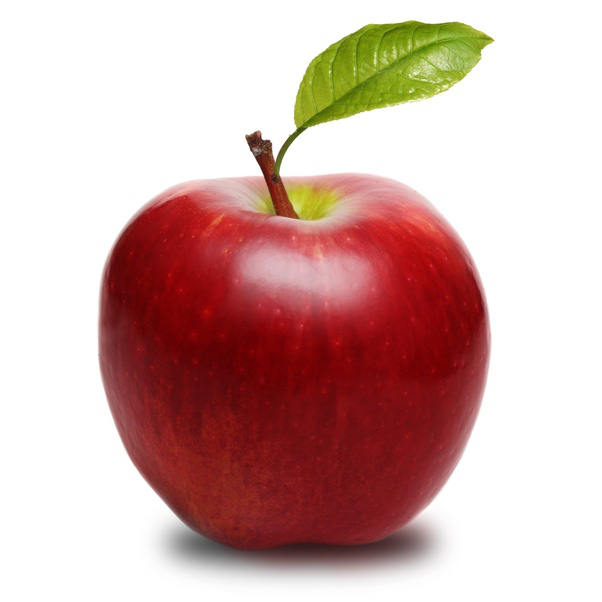

In [58]:
img = PILImage.create(btn_upload.data[-1])
img

* An `Output` widget is something you can fill in later

In [68]:
out_pl = widgets.Output()
out_pl.clear_output()
out_pl

Output()

I now can run another cell, to update the placeholder:

In [60]:
with out_pl:
    display(img.to_thumb(128, 128))

I can use a `Label` to display them

In [69]:
lbl_pred = widgets.Label()
lbl_pred.value = 'Please choose an image'
lbl_pred

Label(value='Please choose an image')

Then another button for classification (doesn't do anything yet)

In [70]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

... now build an event handler: a function that is called when it's pressed

In [74]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Prob: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

Can now put them all together in a VBox (a vertical button widgets)

In [72]:
btn_upload = widgets.FileUpload()

In [75]:
widgets.VBox([widgets.Label('Select your fruit'),
     btn_upload, btn_run, out_pl, lbl_pred])

## 00:28:58 - Voila

* Needs to be installed:

In [77]:
!pip install voila > /dev/null 2>&1
!jupyter serverextension enable voila --sys-prefix

Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.2.10 OK


Takes a notebooks and removes the code cells. Converting into an application that can only run the widgets.

* [Mybinder](https://mybinder.org/) can convert a notebook into a free website. 